In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# 1. 학습 데이터 준비

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 4.6 MB/s 
     |████████████████████████████████| 37.1 MB 48 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

# 1-1. Keypoint csv 파일을 npy 파일로 변환

이미지 이름이 한글로 된 경우 colab에서 인식이 안될 수 있기 때문에 jamo 패키지를 이용해 한글 표기 방식을 바꿔줍니다.



```
! pip install jamo

from jamo import h2j
h2j(## 변환하고자 하는 한글 문자열 ##)
```





이미지 이름이 영어인 경우 사용하지 않아도 됩니다.

keypoint 라벨 csv 파일을 불러와 확인합니다.

In [ ]:
key_df = pd.read_csv("## 라벨 csv 파일 경로 ##")
key_df.head()

,label,x,y,id,width,height
0,cup,175,73,codescombine_1.png,227,166
1,cup,197,105,codescombine_1.png,227,166
2,cup,156,153,codescombine_1.png,227,166
3,cup,52,72,codescombine_1.png,227,166
4,cup,29,106,codescombine_1.png,227,166


불러온 csv 파일에서 라벨이 "cup", "gore" 두 가지인 경우 아래 코드를 사용하여 npy 파일로 변환합니다.

In [ ]:
dict_list = []
id_list = np.unique(key_df['id'])

for id in id_list:
    # 해당 id 이미지의 keypoints 좌표 & 라벨 리스트를 생성합니다.
    keypoints = []
    labels = []

    gore_df = key_df.loc[key_df['id'] == id].loc[key_df['label'] == 'gore']
    cup_df = key_df.loc[key_df['id'] == id].loc[key_df['label'] == 'cup']

    # cup 라벨의 좌표가 6개(왼쪽 컵 3개 + 오른쪽 컵 3개)가 아닌 경우 라벨링이 잘못된 것이므로
    # 해당 제품은 제외하고 다음 제품으로 넘어갑니다.
    if len(cup_df) != 6: 
        continue

    ## 1. keypoints 좌표 & 라벨 리스트에 gore1, gore2를 추가합니다 ## 

    # 고어 너비의 길이가 0일 때 gore 라벨의 좌표는 1개입니다.
    if len(gore_df) == 1:
        gore1 = (gore_df.iloc[0]['x'], gore_df.iloc[0]['y'])
        keypoints.extend([gore1, gore1]) # npy로 변환 시 같은 좌표값을 가지는 gore1, gore2 좌표를 생성합니다.
        labels.extend(['gore1', 'gore2'])

    # 고어 너비의 길이가 0보다 클 때 gore 라벨의 좌표는 2개입니다.
    elif len(gore_df) == 2:
        gore1 = (gore_df.iloc[0]['x'], gore_df.iloc[0]['y'])
        gore2 = (gore_df.iloc[1]['x'], gore_df.iloc[1]['y'])

        # gore1(왼쪽 gore)의 x좌표는 gore2(오른쪽 gore)의 x좌표보다 작습니다.
        if gore1[0] > gore2[0]:
            gore1, gore2 = gore2, gore1

        keypoints.extend([gore1, gore2])
        labels.extend(['gore1', 'gore2'])

    # gore1(왼쪽 gore)보다 왼쪽에 위치한 왼쪽 cup 라벨의 좌표가 3개가 아닌 경우 라벨링이 잘못된 것이므로
    # 해당 제품은 제외하고 다음 제품으로 넘어갑니다.
    if len(cup_df.loc[cup_df['x'] < gore1[0]]) != 3:
        continue
    
    ## 2. keypoints 좌표 & 라벨 리스트에 cup1, cup2의 top, wire, bottom을 추가합니다. ##

    # 왼쪽 cup(cup1) 라벨의 좌표 중 y좌표값이 작은(높이가 높은) 순서대로 top, wire, bottom입니다.
    top, wire, bottom = cup_df.loc[cup_df['x'] < gore1[0], 'y'].sort_values().index
    cup1_top, cup1_wire, cup1_bottom = (cup_df.loc[top, 'x'], cup_df.loc[top, 'y']), (cup_df.loc[wire, 'x'], cup_df.loc[wire, 'y']), (cup_df.loc[bottom, 'x'], cup_df.loc[bottom, 'y'])

    # 오른쪽 cup(cup2) 라벨의 좌표 중 y좌표값이 작은(높이가 높은) 순서대로 top, wire, bottom입니다.
    top, wire, bottom = cup_df.loc[cup_df['x'] > gore1[0], 'y'].sort_values().index
    cup2_top, cup2_wire, cup2_bottom = (cup_df.loc[top, 'x'], cup_df.loc[top, 'y']), (cup_df.loc[wire, 'x'], cup_df.loc[wire, 'y']), (cup_df.loc[bottom, 'x'], cup_df.loc[bottom, 'y'])

    keypoints.extend([cup1_top, cup1_wire, cup1_bottom, cup2_top, cup2_wire, cup2_bottom])
    labels.extend(['cup1_top', 'cup1_wire', 'cup1_bottom', 'cup2_top', 'cup2_wire', 'cup2_bottom'])

    ## 3. 해당 제품의 id와 keypoints 좌표, 라벨을 dictionary로 변환하여 dictionary 리스트에 추가합니다. ##
    dict_list.append({'id': id.split('.')[0], 'keypoints': keypoints, 'labels':labels})

In [ ]:
# dictionary 리스트를 npy 파일로 변환하여 저장합니다.
np.save("## npy 파일 경로 ##", dict_list)

# 1-2. Image Resize & Augmentation

**Resize**

크기가 다른 학습 이미지를 모델에 입력하기 위해선 이미지의 크기를 통일해야 합니다. 이미지의 사이즈가 너무 크면 학습이 오래 걸리고, 사이즈가 너무 작으면 이미지 손실로 인해 정확한 학습이 어렵습니다. 적절한 사이즈의 "정사각형" 이미지로 변환해야 학습에 용이합니다.


**Augmentation**

라벨링된 학습 이미지가 적을 때, 이미지에 변형을 주어 학습 이미지 개수를 늘리는 방식을 Augmentation (부풀리기) 라고 합니다. 

라벨링 된 이미지를 변형하면 각 라벨의 keypoint 좌표값 역시 함께 변화해야 합니다. 

keypoint와 이미지를 함께 변형하기 위해 **Albumentation** API를 이용합니다.

* Albumentation 사용에 대한 설명 및 예시입니다. A.Compose의 매개변수에 대한 설명이 구체적으로 적혀있습니다.

    https://albumentations.ai/docs/getting_started/keypoints_augmentation/


* Resize API의 매개변수에 대한 설명입니다. (이미지 resize)

    https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/api/augmentations.html#albumentations.augmentations.transforms.ShiftScaleRotate

* ShiftScaleRotate API의 매개변수에 대한 설명입니다. (이미지 augmentation)

    https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/api/augmentations.html#albumentations.augmentations.transforms.Resize

In [ ]:
class_labels = ['gore1', 'gore2', 'cup1_top', 'cup1_wire', 'cup1_bottom', 'cup2_top', 'cup2_wire', 'cup2_bottom']

# 이미지 크기를 128 x 128 로 resize 하는 함수를 생성합니다.
resize = A.Compose(
    [A.Resize(128, 128)],
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=True)
)

# 이미지를 지정한 범위 내에서 랜덤으로 회전, 확대, 이동하여 변형하는 함수를 생성합니다.
transform = A.Compose(
    [A.ShiftScaleRotate(rotate_limit=15, scale_limit=0.2, shift_limit_x=0.1, shift_limit_y=0.2, border_mode=cv2.BORDER_REPLICATE, p=1)],
    keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels'], remove_invisible=False)
)

Albumentation의 Resize 함수만 이용해 특정 사이즈의 정사각형 이미지로 변환할 경우 기존 이미지의 비율도 바뀌기 때문에 적절하지 않습니다. resize 함수를 적용하기 전, **get_square_image** 함수를 이용해 정사각형 이미지로 변환합니다.

In [ ]:
# 이미지의 비율을 유지하여 정사각형 이미지로 resize하는 함수

def get_square_image(img, keypoints):
    h = img.shape[0] # 이미지의 세로 길이
    w = img.shape[1] # 이미지의 가로 길이

    if h < w: # 가로가 세로보다 길 경우 위, 아래에 여백을 추가합니다.
        img_border = cv2.copyMakeBorder(img, int((w-h)/2), int((w-h)/2), 0, 0, cv2.BORDER_REPLICATE)
        new_keypoints = [(x, y + int(w-h)/2) for (x, y) in keypoints] # 이미지 위에 여백이 붙은 만큼 y좌표값을 수정합니다.
        
    else: # 세로가 가로보다 길 경우 양 옆에 여백을 추가합니다.
        img_border = cv2.copyMakeBorder(img, 0, 0, int((h-w)/2), int((h-w)/2), cv2.BORDER_REPLICATE)
        new_keypoints = [(x + int(h-w)/2, y) for (x, y) in keypoints] # 이미지 왼쪽에 여백이 붙은 만큼 x좌표값을 수정합니다.

    return img_border, new_keypoints # 변환된 이미지 ndarray와 변환된 keypoints 리스트를 반환합니다.

Augmentation을 진행하기 전에 tranform 함수의 매개변수 설정이 적절한지 확인합니다. 

이미지 변형이 지나치게 크거나 거의 없는 경우 매개변수 값을 수정합니다.

In [ ]:
# 이미지에 keypoints를 표시하여 출력하는 함수
def vis_keypoints(image, keypoints, ax):
    image = image.copy()
    for (x, y) in keypoints:
        cv2.circle(image, (int(x), int(y)), 2, (0, 0, 255), -1)
    
    ax.imshow(image)
    ax.set_xticks([]), ax.set_yticks([])

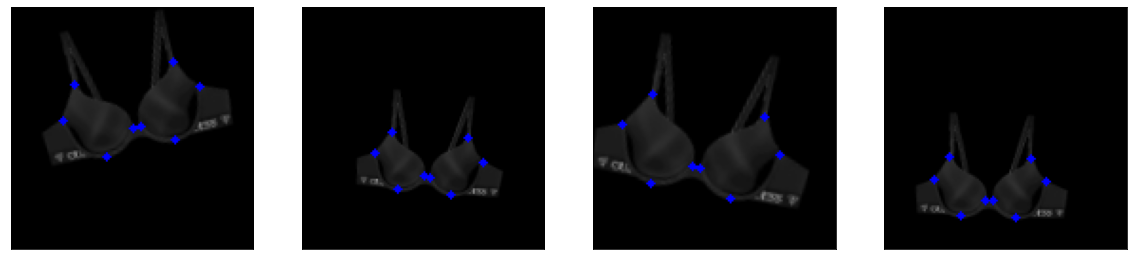

In [ ]:
# 이미지 파일과 npy 파일을 불러옵니다.
keypoints_npy = np.load("## npy 파일 경로 ##", allow_pickle=True)
npy_id_list = [dictionary['id'] for dictionary in keypoints_npy] 

img_list = glob.glob("## 이미지 폴더 경로/* ##")
img_id = [os.path.basename(image).split('.')[0] for image in img_list]

## 임의의 이미지에 대하여 resize 및 augmentation을 진행하고 출력합니다. ##
id = npy_id_list[0]
img = cv2.imread(img_list[img_id.index(id)])
keypoints = keypoints_npy[0]['keypoints']

# 128 x 128 resize
square_img, square_keypoints = get_square_image(img, keypoints)
resized = resize(image=img, keypoints=square_keypoints, class_labels=class_labels)

# augmentation 출력
fig = plt.figure(figsize=(20, 20))
for i in range(1, 5):
    transformed = transform(image=resized['image'], keypoints=resized['keypoints'], class_labels=class_labels)
    ax = fig.add_subplot(1, 4, i)
    vis_keypoints(transformed['image'], transformed['keypoints'], ax)

앞서 생성한 resize, transform 함수와 get_square_image 함수를 이용해 이미지 resize 및 augmentation을 진행합니다.

In [ ]:
import glob
import os

# 앞서 생성한 keypoints 좌표 & 라벨 npy 파일을 불러옵니다.
keypoints_npy = np.load("## npy 파일 경로 ##", allow_pickle=True)
npy_id_list = [dictionary['id'] for dictionary in keypoints_npy] # npy 파일의 id 리스트를 반환합니다.

# 이미지 파일들을 불러옵니다.
img_list = glob.glob('## 이미지 폴더 경로/* ##') # 이미지 파일 경로 리스트를 반환합니다.
img_id = [os.path.basename(image).split('.')[0] for image in img_list] # 반환된 이미지 파일 경로에서 이미지 이름만 추출합니다.

augmented_npy = []
image_save_dir = "## resized & augmented 이미지를 저장할 폴더 경로 ##"

for id in npy_id_list: # keypoint 좌표 & 라벨을 가진 제품 중 
    if id in img_id: # 이미지 파일을 가진 제품에 대해서 이미지 증강을 진행합니다.

        # 해당 id의 이미지를 ndarray로 불러옵니다
        img = cv2.imread(img_list[img_id.index(id)], 0)

        # 해당 id의 keypoint 좌표 리스트를 불러옵니다.
        keypoints = keypoints_npy[npy_id_list.index(id)]['keypoints']


        ## 1. 이미지 비율을 유지하여 (128, 128)로 resize 합니다. ##

        square_img, square_keypoints = get_square_image(img, keypoints) # 이미지 비율 유지하여 정사각형으로 변환합니다.
        resized = resize(image=img, keypoints=square_keypoints, class_labels=class_labels) # 이미지 크기를 (128, 128)로 resize 합니다.

        # resize 한 이미지를 지정된 폴더에 저장하고
        # id와 keypoints 좌표를 dictionary로 변환하여 dictionary 리스트에 추가합니다.
        cv2.imwrite(image_save_dir + id + '.png', resized['image'])
        augmented_npy.append({'id': id, 'keypoints': resized['keypoints']})


        ## 2. 학습 이미지를 부풀리기 위해 이미지 형태에 변화를 줍니다. ##

        for i in range(1, ## n ##): # 이미지를 n배 부풀립니다.
            
            # 앞서 trasform에 지정한 범위 내에서 이미지 형태에 변화를 줍니다.
            transformed = transform(image=resized['image'], keypoints=resized['keypoints'], class_labels=class_labels)

            # 변형한 이미지를 지정된 폴더에 저장하고
            # id와 keypoints 좌표를 dictionary로 변환하여 dictionary 리스트에 추가합니다.
            aug_id = id + '_aug' + str(i)
            dst_dir = image_save_dir + aug_id + '.png'
            cv2.imwrite(dst_dir, transformed['image'])
            augmented_npy.append({'id': aug_id, 'keypoints': transformed['keypoints']})

# 2. 모델 학습

1. 학습 & 평가 데이터를 생성합니다.

In [ ]:
import numpy as np
import glob
import os
import cv2

In [ ]:
# 1. 학습 이미지와 keypoints 좌표값을 불러옵니다.

image_list = glob.glob("## 학습 이미지 폴더 경로/* ##")
image_id = [os.path.basename(image).split('.')[0] for image in image_list]

keypoints_npy = np.load("## 학습 이미지 keypoints npy 파일 경로 ##", allow_pickle=True)
npy_id_list = [dictionary['id'] for dictionary in keypoints_npy] 

# 원본 + 변형 이미지 전체 리스트
total_images = []
total_y = []


for id in npy_id_list:
    if id in image_id:
        i = image_id.index(id)
        # channel: 1 인 image array를 형성하고 total_images 리스트에 추가합니다.
        img = cv2.imread(image_list[i], 0)
        total_images.append(img)

        # 각 image array에 해당하는 keypoints array 를 형성하고 total_y 리스트에 추가합니다.
        keypoints = []
        for point in keypoints_npy[npy_id_list.index(id)]['keypoints']:
            keypoints.extend([round(v, 2) for v in list(point)])
        total_y.append(keypoints)


# 0~255 의 값을 가지는 이미지 pixel 값들을 0~1로 정규화합니다.
total_images = np.array(total_images) / 255

X = total_images.reshape(-1, 128, 128, 1)
y = np.array(total_y, dtype='float')

In [ ]:
# 2. 학습 데이터, 평가 데이터로 분할합니다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

2. 모델 생성 ( 조정 중 )

* input_shape = (128, 128, 1) : image
* output_shape = (16, ) : keypoints

    shape = (128, 128, 1) 인 이미지 array에 대해서 [gore1_x, gore1_y, ... , cup2_bottom_x, cup2_bottom_y] 리스트의 값들을 예측합니다.

In [ ]:
# 모델 생성

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(16))
model.summary()

In [ ]:
# 모델 컴파일

from keras.optimizers import SGD, Adam

LR = 0.001

model.compile(optimizer=Adam(LR), 
              loss='mean_squared_error', 
              metrics=['mae'])

3. 모델 가중치를 학습합니다.

In [ ]:
from keras.callbacks import EarlyStopping

# 20번의 epoch 동안 val_loss가 더 이상 작아지지 않을 경우 학습을 중단합니다.
es = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [ ]:
EPOCHS = 300
BATCH_SIZE = 200

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split=0.1,
                    callbacks=[es])

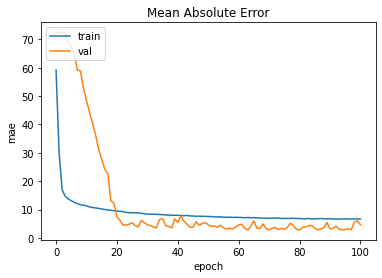

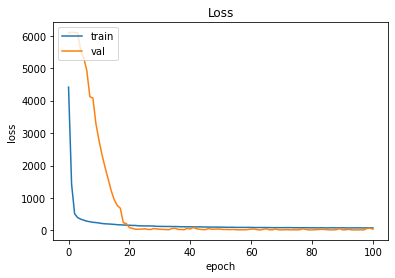

In [ ]:
# 학습 시각화
import matplotlib.pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

4. 모델 정확도를 평가하고 예측한 keypoint를 시각화합니다.

In [ ]:
# 평가 데이터에 대하여 절대값 오차와 제곱근 오차를 계산합니다.

from sklearn.metrics import mean_absolute_error, mean_squared_error

pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
print("Mean Absolute Error: {0:.4f}".format(mae))
print("Mean Squared Error: {0:.4f}".format(mse))

Mean Absolute Error: 2.4956
Mean Squared Error: 12.2384


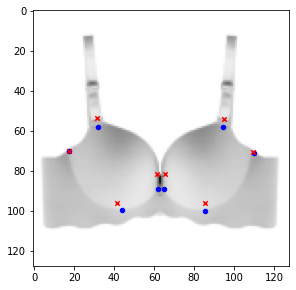

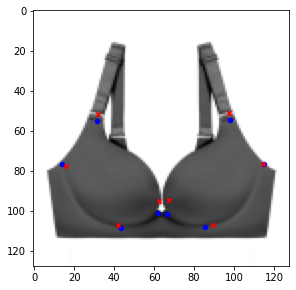

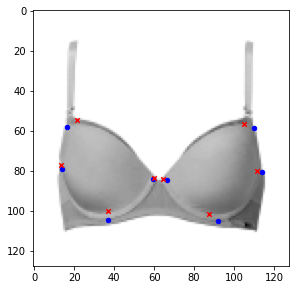

In [ ]:
# 평가 데이터의 이미지 중 임의로 3개를 뽑아 예측한 keypoints를 시각화합니다.

import matplotlib.pyplot as plt
import random

for i, num in enumerate(random.sample(range(len(y_test)), 3)):
    plt.figure(figsize=(16, 16))
    plt.subplot(3, 1, i+1)
    plt.imshow(X_test[num].reshape(128, 128), 'gray')
    for j in range(0, 15, 2):
        plt.scatter(y_test[num][j], y_test[num][j+1], s=20, marker='o', c='b')
        plt.scatter(pred[num][j], pred[num][j+1], s=20, marker='x', c='r')

5. 학습된 모델을 저장합니다.

이전 모델보다 정확도가 개선된 경우 현재 학습된 모델을 저장합니다.

In [ ]:
# 같은 경로로 다른 모델을 저장할 경우 이전 모델 정보가 사라지기 때문에 경로 설정에 주의합니다.

model.save("## 가중치가 학습된 모델 저장 경로 ##", overwrite=False)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Likenot_ML/Keypoint/model_4/assets


( 6. 모델 불러오기 ) 

In [ ]:
import keras

model = keras.models.load_model("## 저장된 모델 경로 ##")

In [ ]:
# 모델 구조를 시각화합니다.

!pip install graphviz
!pip install pydot

from IPython.display import SVG
from keras.utils.vis_utils import plot_model

plot_model(model, 'model_4.png', show_shapes=True)

# 3. 새로운 이미지의 keypoint 예측

In [ ]:
import numpy as np
import pandas as pd
import cv2

1. 새로운 이미지를 ndarray 형태로 준비합니다.

In [ ]:
# 이미지의 비율을 유지하여 정사각형 이미지로 resize하는 함수

def get_resized_image(img, resize_shape): # shape: 세로, 가로 길이가 같은 정사각형의 튜플
    h = img.shape[0] # 이미지의 세로 길이
    w = img.shape[1] # 이미지의 가로 길이

    if h < w: # 가로가 세로보다 길 경우 위, 아래에 여백을 추가합니다.
        img_border = cv2.copyMakeBorder(img, int((w-h)/2), int((w-h)/2), 0, 0, cv2.BORDER_REPLICATE)    
    else: # 세로가 가로보다 길 경우 양 옆에 여백을 추가합니다.
        img_border = cv2.copyMakeBorder(img, 0, 0, int((h-w)/2), int((h-w)/2), cv2.BORDER_REPLICATE)

    # 정사각형 이미지의 크기를 resize_shape로 변환합니다.
    img_resized = cv2.resize(img_border, resize_shape, interpolation=cv2.INTER_AREA)

    return img_resized

In [ ]:
# 예측할 이미지를 ndarray 형태로 불러옵니다.

filepath = '### 이미지 경로 설정 ###'

images_arr = []
image_id = []

for filename in os.listdir(filepath):
    image = cv2.imread(os.path.join(filepath, filename), 0)
    resized_img = get_resized_image(image, (128, 128)) # 이미지 비율을 유지하여 128 x 128로 resize 합니다.

    images_arr.append(resized_img)
    image_id.append(filename.split('.')[0])

images_arr = np.array(images_arr) / 255 # rescale=1/255
new_images = images_arr.reshape(-1, 128, 128, 1)

2. 저장한 모델 불러와 keypoint를 예측합니다.

In [ ]:
import keras

# 저장된 모델을 불러옵니다.
model = keras.models.load_model('### 모델 폴더 저장 경로 ###')

# 새로운 이미지의 keypoint를 예측합니다.
pred_keypoints = model.predict(new_images) 

In [ ]:
# 이미지의 id, 예측 keypoint, label을 dictionary 형태로 저장합니다.

pred_keypoint_dict_list = []
labels = ['gore1', 'gore2','cup1_top', 'cup1_wire', 'cup1_bottom', 'cup2_top', 'cup2_wire', 'cup2_bottom']

for i in range(len(image_id)):
    id = image_id[i]
    keypoints = [round(x, 0) for x in pred_keypoint[i]]

    gore1 = (keypoints[0], keypoints[1])
    gore2 = (keypoints[2], keypoints[3])

    cup1_top = (keypoints[4], keypoints[5])
    cup1_wire = (keypoints[6], keypoints[7])
    cup1_bottom = (keypoints[8], keypoints[9])

    cup2_top = (keypoints[10], keypoints[11])
    cup2_wire = (keypoints[12], keypoints[13])
    cup2_bottom = (keypoints[14], keypoints[15])

    keypoints_list = [gore1, gore2, cup1_top, cup1_wire, cup1_bottom, cup2_top, cup2_wire, cup2_bottom]
    pred_keypoint_dict_list.append({'id': image_id[i], 'keypoints': keypoints_list, 'labels': labels})

In [ ]:
# dictionary를 npy 파일로 저장합니다.
np.save('### npy파일 저장 경로 ###', pred_keypoint_dict_list)

3. 예측한 keypoints를 시각화합니다.

In [ ]:
# 새로운 이미지 중 임의로 3개를 뽑아 예측한 keypoints를 시각화합니다.

import matplotlib.pyplot as plt
import random

for i, num in enumerate(random.sample(range(len(pred_keypoints)), 3)):
    plt.figure(figsize=(16, 16))
    plt.subplot(3, 1, i+1)
    plt.imshow(new_images[num].reshape(128, 128), 'gray')
    for j in range(0, 15, 2):
        plt.scatter(pred_keypoints[num][j], pred_keypoints[num][j+1], s=20, marker='x', c='r')

# 4. 예측한 keypoint로 고어 높이 라벨 분류

In [ ]:
#class_labels = ['gore1', 'gore2', 'cup1_top', 'cup1_wire', 'cup1_bottom', 'cup2_top', 'cup2_wire', 'cup2_bottom']

# 예측한 keypoint 파일을 불러옵니다.
pred_keypoints_npy = np.load('### npy파일 저장 경로 ###')
goreHeight_pred = pd.DataFrame(columns=['ID', 'wire2cup', 'gore2wire'])

# 각 이미지의 컵 높이, 와이어 높이, 고어 높이를 계산한 후
# 와이어 높이 / 컵 높이, 고어 높이 / 와이어 높이 의 비율을 계산합니다.
for i in range(len(pred_keypoints_npy)):
    item = pred_keypoints_npy[i]
    goreHeight_pred.loc[i, 'ID'] = item['id']

    cup_y = round(item['keypoints'][2][1] + item['keypoints'][5][1] / 2, 1) # cup1_top[y] + cup2_top[y] / 2
    wire_y = round(item['keypoints'][3][1] + item['keypoints'][6][1] / 2, 1) # cup1_wire[y] + cup2_wire[y] / 2
    bottom_y = round(item['keypoints'][4][1] + item['keypoints'][7][1] / 2, 1) # cup1_bottom[y] + cup2_bottom[y] / 2
    gore_y = round(item['keypoints'][0][1] + item['keypoints'][1][1] / 2, 1) # gore1[y] + gore2[y] / 2

    cup_len = bottom_y - cup_y
    wire_len = bottom_y - wire_y
    gore_len = bottom_y - gore_y
    
    goreHeight_pred.loc[i, 'wire2cup'] = round(wire_len / cup_len, 2) 
    goreHeight_pred.loc[i, 'gore2wire'] = round(gore_len / wire_len, 2)

In [ ]:
# 와이어 높이가 컵에서 차지하는 비율에 따라 고어 높이 라벨의 분류 비율이 달라지도록 설정합니다.
# 분류 기준은 임의로 설정한 것이므로, 정확한 고어 높이 라벨을 예측하기 위해선 추가적인 수정이 필요합니다.

def get_height_label(wire2cup, gore2wire):
    if wire2cup < 0.45:
        if gore2wire < 0.8:
            label = 0
        else:
            label = 1
    elif wire2cup < 0.65:
        if gore2wire < 0.5:
            label = 0
        elif gore2wire < 0.7:
            label = 1
        else:
            label = 2
    else:
        if gore2wire < 0.45:
            label = 0
        elif gore2wire < 0.65:
            label = 1
        else:
            label = 2

    return label

In [ ]:
# 앞서 생성한 goreHeight_pred data frame에 분류한 고어 높이 라벨 정보를 추가합니다.

for i in goreHeight_pred.index:
    goreHeight_pred.loc[i, 'height_label'] = get_height_label(goreHeight_pred.loc[i, 'wire2cup'], goreHeight_pred.loc[i, 'gore2wire'])
  
goreHeight_pred['height_label'] = goreHeight_pred['height_label'].astype(int)

In [ ]:
# goreHeight_pred data frame 을 저장합니다.
goreHeight_pred.to_csv('### 고어 높이 예측 csv파일 저장 경로 ###', index=False)